BM20A6100 Project work Forecasting power for predicting temperature using multivariate data

Emma Hirvonen, Helmi Toropainen, Jan Vymazal

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
import itertools
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import SGD, Adam
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

# Data import pretreatment

In [4]:
# Import dataset with Pandas
file_path = "sample_data/DailyDelhiClimateTrain.csv"
climate_data = pd.read_csv(file_path, parse_dates=["date"])
climate_data = climate_data.set_index("date") # use date as index
print(climate_data.info())
print(climate_data.head())
print(climate_data.describe())
# Data consists of 4 variables for 1462 samples, no missing values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB
None
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000
          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802

<Figure size 640x480 with 0 Axes>

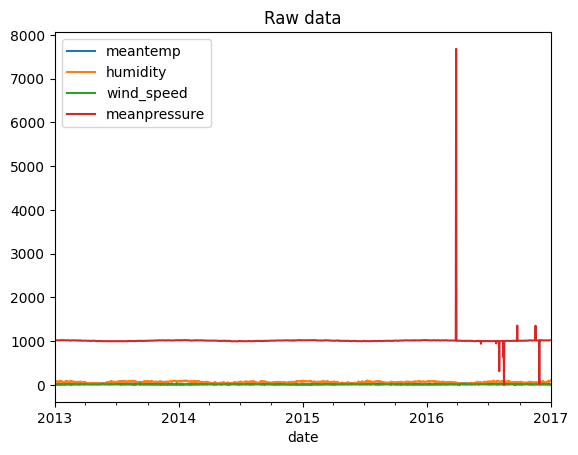

<Figure size 640x480 with 0 Axes>

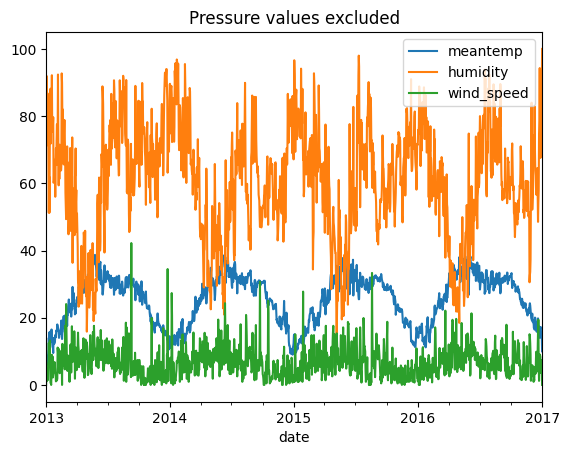

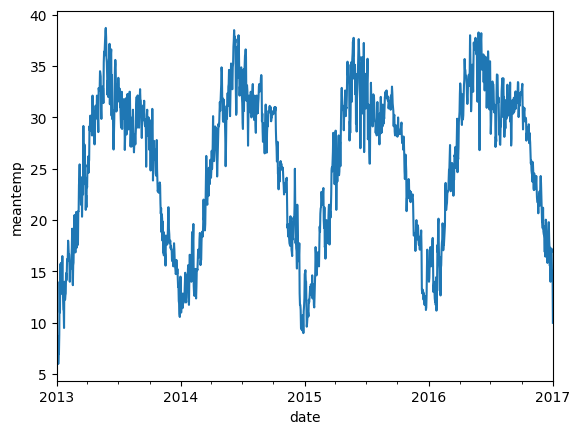

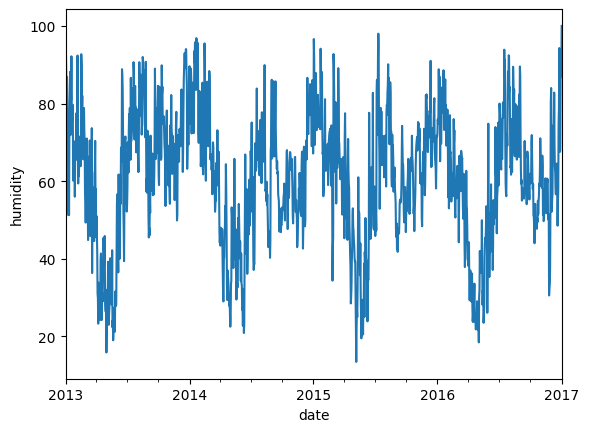

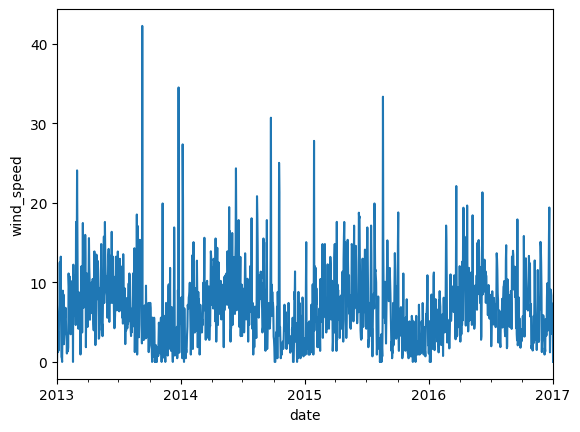

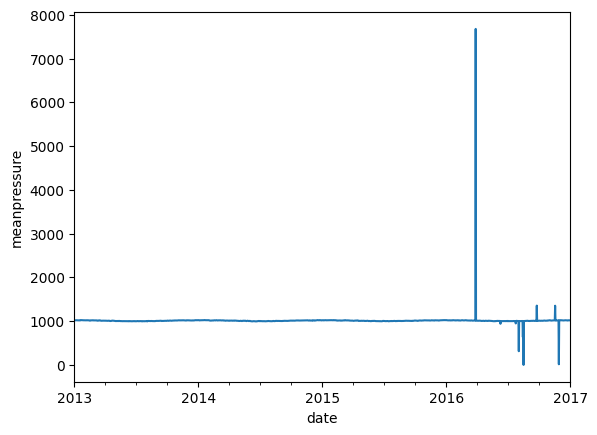

In [5]:
# Visualise timerseries for all variables

plt.figure()
climate_data.plot()
plt.title("Raw data")
plt.show()

plt.figure()
climate_data.drop("meanpressure", axis=1).plot()
plt.title("Pressure values excluded")
plt.show()

for var in climate_data.columns:
  plt.figure()
  climate_data[var].plot()
  plt.ylabel(var)
  plt.show()

In [6]:
# replace outlier
print(climate_data[climate_data["meanpressure"] > 2000]) # outlier?
climate_data_clean = climate_data.copy()

t = pd.Timestamp(climate_data_clean[climate_data_clean["meanpressure"] > 2000].index.date[0]) # outlier date
i = climate_data_clean.index.get_loc(t) # outlier index

new_pressure = (climate_data_clean.iloc[i+1].get("meanpressure")+climate_data_clean.iloc[i-1].get("meanpressure"))/2 # average of prev and next value

climate_data_clean.loc[t, "meanpressure"] = new_pressure

             meantemp  humidity  wind_speed  meanpressure
date                                                     
2016-03-28  25.933333      52.8    6.546667   7679.333333


<Figure size 640x480 with 0 Axes>

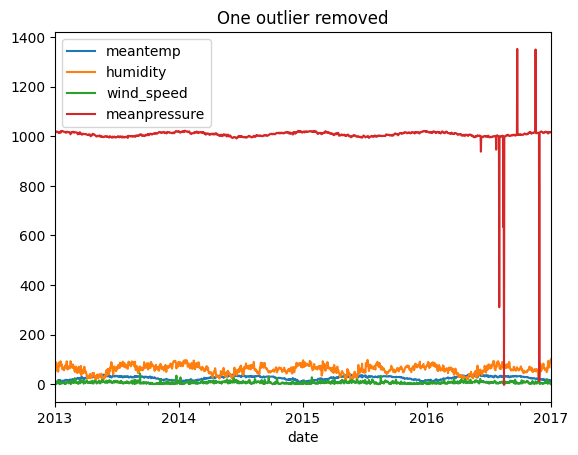

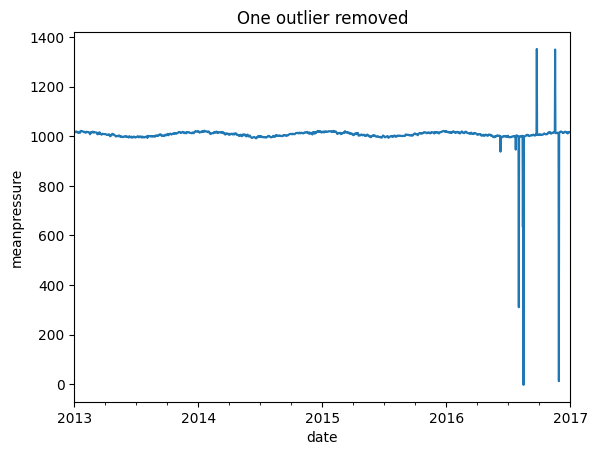

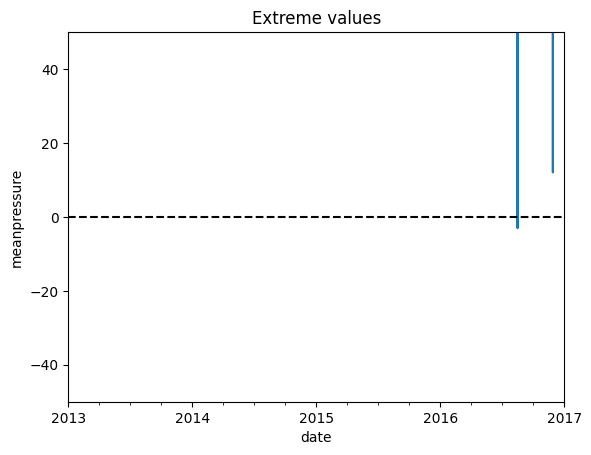

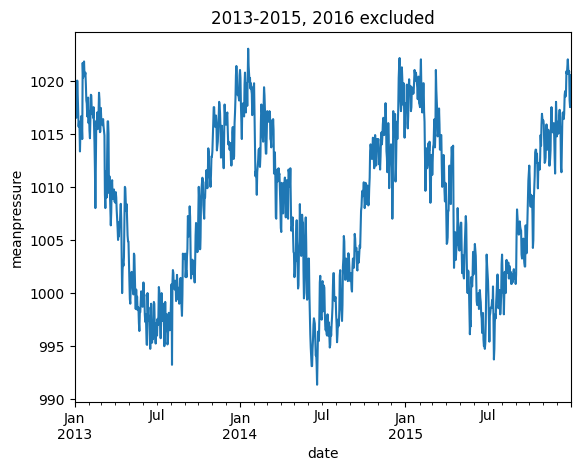

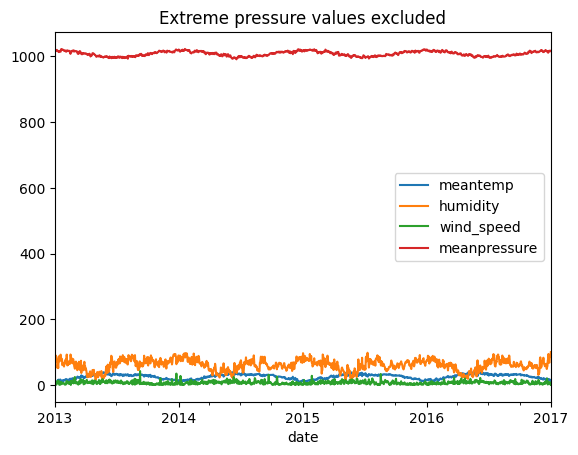

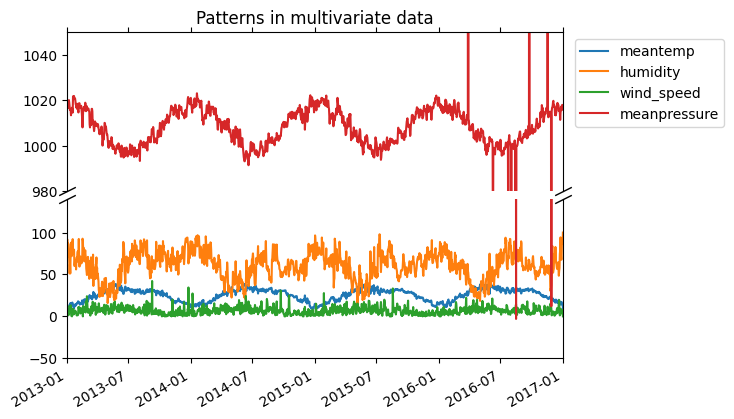

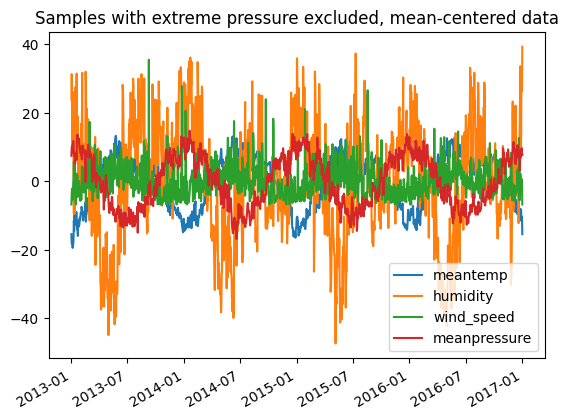

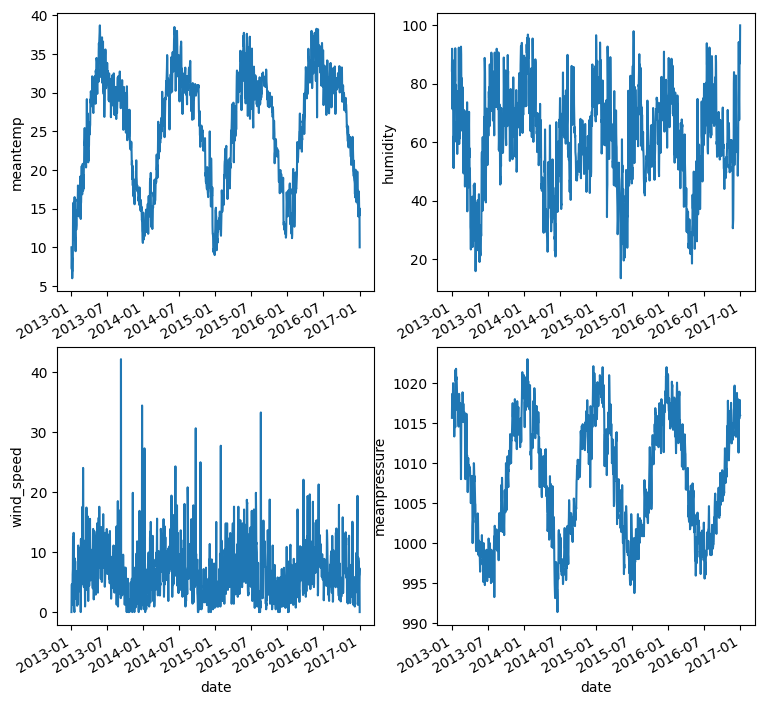

In [7]:
# new plots without outlier
plt.figure()
climate_data_clean.plot()
plt.title("One outlier removed")
plt.show()

plt.figure()
climate_data_clean["meanpressure"].plot()
plt.ylabel("meanpressure")
plt.title("One outlier removed")
plt.show()

# negative pressure?
plt.figure()
climate_data["meanpressure"].plot()
plt.ylabel("meanpressure")
plt.axhline(y=0, color='k', linestyle='--')
plt.ylim(-50, 50)
plt.title("Extreme values")
plt.show()

# pressure values from 2013-01-01 to 2016-01-01 (2016 seems unreliable?)
plt.figure()
climate_data.iloc[0:365+365+365, 3].plot()
plt.ylabel("meanpressure")
plt.title("2013-2015, 2016 excluded")
plt.show()
# all values should be between ~990-1030?

# skip outlier values
climate_data.drop("meanpressure", axis=1).plot()
climate_data.query("990 < meanpressure < 1030")["meanpressure"].plot()
plt.legend()
plt.title("Extreme pressure values excluded")
plt.show()

# broken y-axis (matplotlib documentation)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)
plt_data = climate_data#.query("990 < meanpressure < 1030")
ax1.plot(plt_data)
ax1.set_ylim((980, 1050))
ax1.set_xlim([datetime.date(2013, 1, 1), datetime.date(2017, 1, 1)])
ax2.plot(plt_data)
ax2.set_ylim((-50, 140))
ax2.set_xlim([datetime.date(2013, 1, 1), datetime.date(2017, 1, 1)])
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()
ax1.legend(plt_data.columns, bbox_to_anchor=(1.01, 1.0), loc='upper left')
ax1.title.set_text("Patterns in multivariate data")
fig.autofmt_xdate()
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
plt.show()

# mean center data
plt.figure()
plt.plot(climate_data.query("990 < meanpressure < 1030") - climate_data.query("990 < meanpressure < 1030").mean())
plt.gcf().autofmt_xdate()
plt.legend(climate_data.columns)
plt.title("Samples with extreme pressure excluded, mean-centered data")
plt.show()

# subplot of all variables (no mean-centering)
plt.figure(figsize=(9, 9))
for i in range(4):
  plt.subplot(2,2,i+1)
  climate_data.query("990 < meanpressure < 1030").iloc[:, i].plot()
  plt.ylabel(climate_data.columns[i])
plt.show()


In [8]:
# Replace outliers in meanpressure

dates = climate_data_clean.query("meanpressure < 990 or meanpressure > 1030").index.date

for date in dates:
  t = pd.Timestamp(date)
  i = climate_data_clean.index.get_loc(t)
  new_pressure = (climate_data_clean.iloc[i+1].get("meanpressure")+climate_data_clean.iloc[i-1].get("meanpressure"))/2 # average of prev and next value
  climate_data_clean.loc[t, "meanpressure"] = new_pressure

climate_data = climate_data_clean.copy()



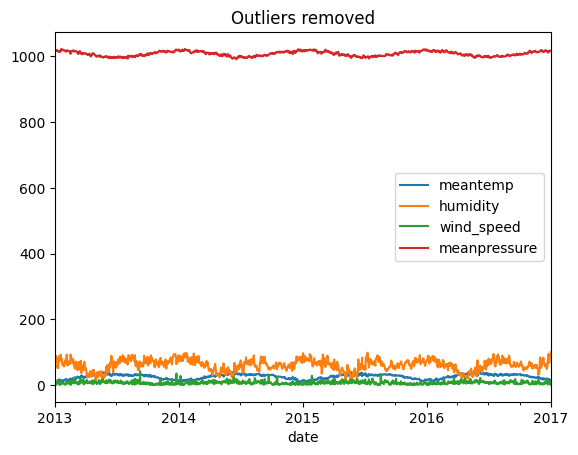

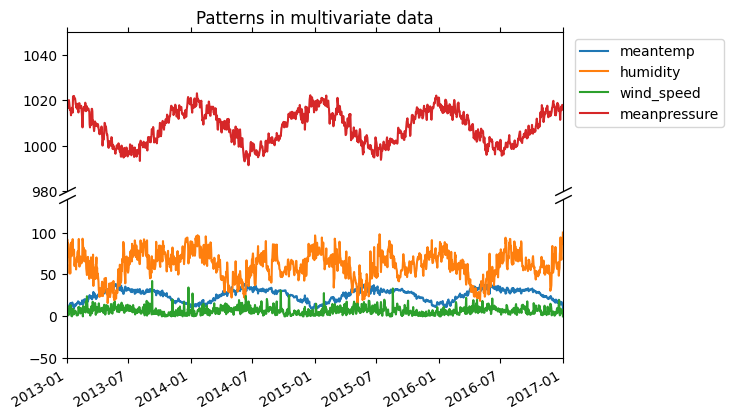

In [9]:
# Outliers replaced
climate_data_clean.plot()
plt.title("Outliers removed")
plt.show()

# broken y-axis (matplotlib documentation)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)
plt_data = climate_data_clean
ax1.plot(plt_data)
ax1.set_ylim((980, 1050))
ax1.set_xlim([datetime.date(2013, 1, 1), datetime.date(2017, 1, 1)])
ax2.plot(plt_data)
ax2.set_ylim((-50, 140))
ax2.set_xlim([datetime.date(2013, 1, 1), datetime.date(2017, 1, 1)])
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()
ax1.legend(plt_data.columns, bbox_to_anchor=(1.01, 1.0), loc='upper left')
ax1.title.set_text("Patterns in multivariate data")
fig.autofmt_xdate()
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
plt.show()

# Time-series decomposition

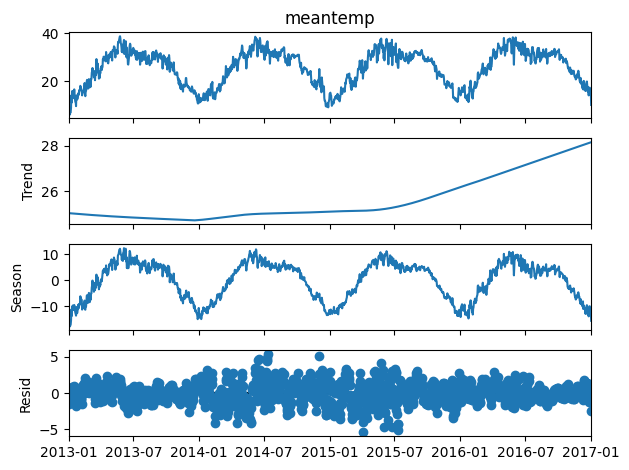

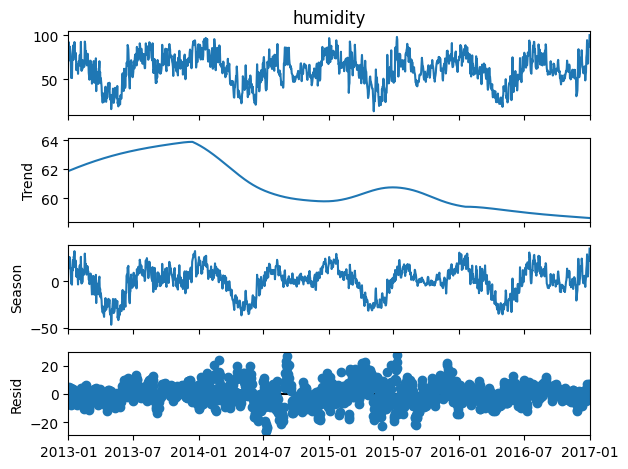

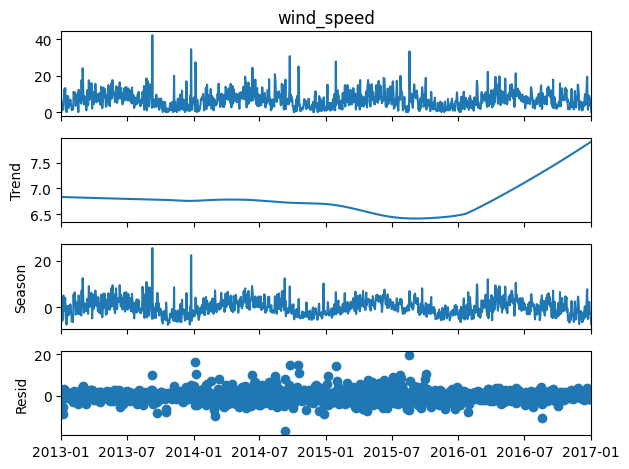

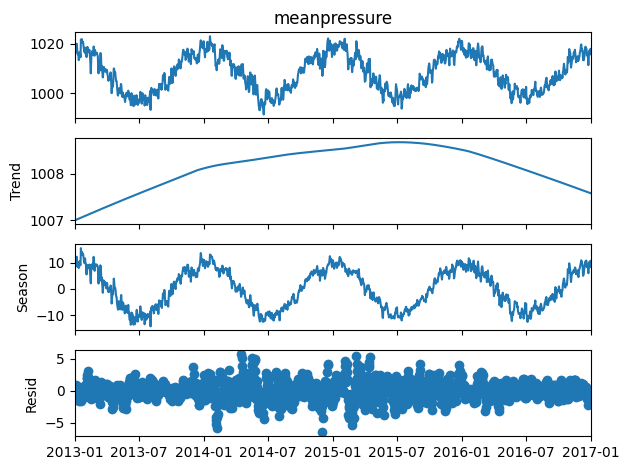

In [10]:
#Time-series decomposition analysis in long-term trend, seasonality and residuals
#Period 365 because we measure once per day for multiple years
stl = STL(climate_data["meantemp"], period=365 )
res = stl.fit()
fig = res.plot()

stl = STL(climate_data["humidity"], period=365)
res = stl.fit()
fig = res.plot()

stl = STL(climate_data["wind_speed"], period=365)
res = stl.fit()
fig = res.plot()

stl = STL(climate_data["meanpressure"], period=365)
res = stl.fit()
fig = res.plot()


Text(0.5, 1.0, 'Mean pressure autocorrelation')

<Figure size 640x480 with 0 Axes>

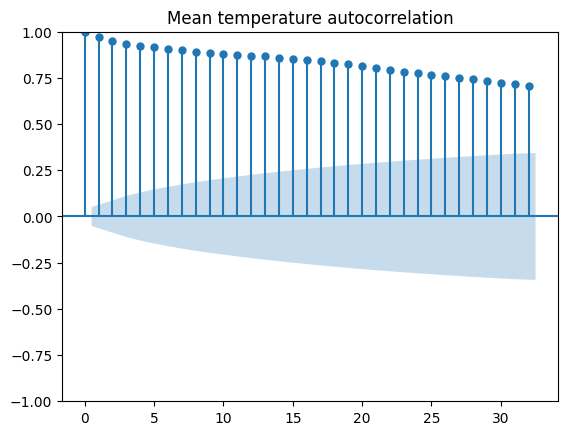

<Figure size 640x480 with 0 Axes>

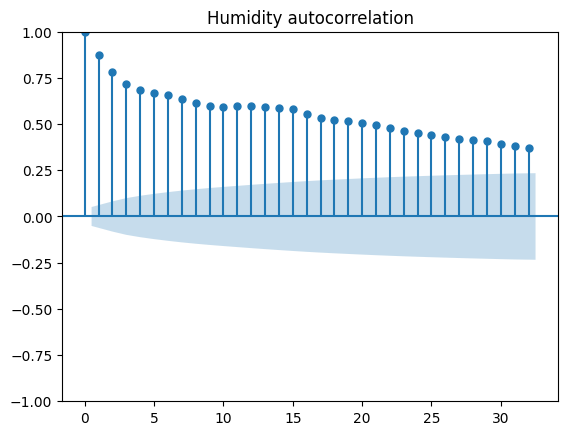

<Figure size 640x480 with 0 Axes>

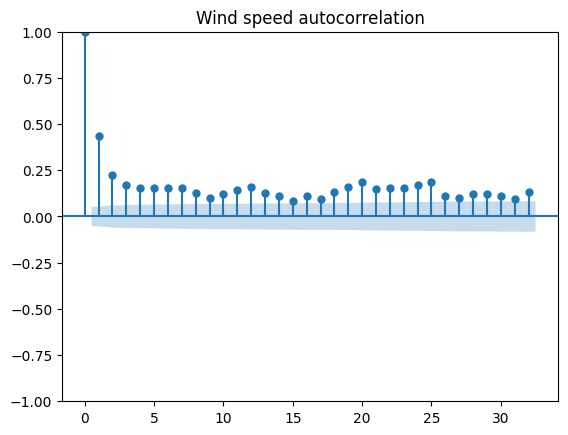

<Figure size 640x480 with 0 Axes>

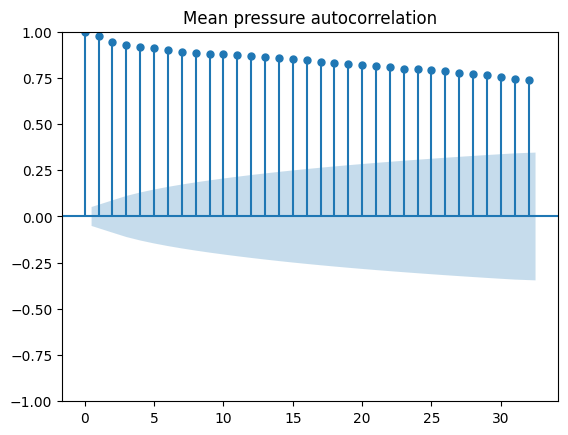

In [11]:
#Autocorrelation analysis of the dataset

plt.figure()
plot_acf(climate_data["meantemp"])
plt.title("Mean temperature autocorrelation")

plt.figure()
plot_acf(climate_data["humidity"])
plt.title("Humidity autocorrelation")

plt.figure()
plot_acf(climate_data["wind_speed"])
plt.title("Wind speed autocorrelation")

plt.figure()
plot_acf(climate_data["meanpressure"])
plt.title("Mean pressure autocorrelation")


# Baseline autoregressive model

In [12]:
# Build the dataset
T =100
X = []
Y = []
series = climate_data['meantemp']
series = (series-series.mean())/series.std() # normalise
series = series.to_numpy()
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1362, 100) Y.shape (1362,)


In [13]:
# Try autoregressive model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001)
)

# train
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.5410 - val_loss: 0.9369
Epoch 2/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7735 - val_loss: 0.2988
Epoch 3/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2683 - val_loss: 0.2316
Epoch 4/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2243 - val_loss: 0.2272
Epoch 5/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2109 - val_loss: 0.2192
Epoch 6/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2190 - val_loss: 0.2118
Epoch 7/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1884 - val_loss: 0.2062
Epoch 8/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1986 - val_loss: 0.1984
Epoch 9/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1710 - val_loss: 0.1921
Epoch 10/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1751 - val_loss: 0.1871
Epoch 11/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1732 - val_loss: 0.1810
Epoch 12/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1695 - val_l

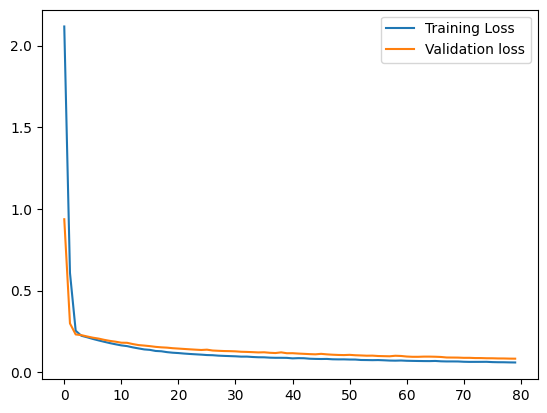

In [14]:
# Plot loss per iteration
plt.plot(r.history["loss"], label="Training Loss")
plt.plot(r.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

In [15]:
# Forecast future values
validation_target = Y[-N//2:]
validation_predictions = []

# Last train input
last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0, 0] # 1x1 array

  # Update predictions list
  validation_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1) # shift everything one spot to the left, we replace it with the latest forecasted prediction. Multi-step predictions.
  last_x[-1] = p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

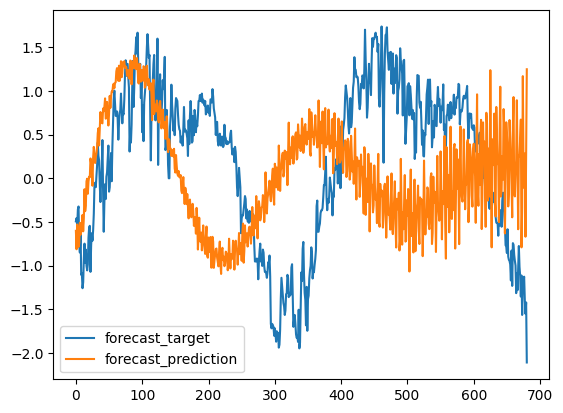

In [16]:
plt.plot(validation_target, label="forecast_target")
plt.plot(validation_predictions, label="forecast_prediction")
plt.legend()
plt.show()

# RNN & LSTM

Dataset for model training

Parts of RNN & LSTM code based on this example : https://www.kaggle.com/code/humagonen/time-series-arima-sarima-prophet-rnn-lstm-gru/notebook


In [17]:
# Creating dataset for model training
df = climate_data_clean
train_split = 0.8
# Split the data into training and testing sets
train_size = int(len(df) * train_split)
dl_train, dl_test = df.iloc[:train_size], df.iloc[train_size:]
print(len(dl_train), len(dl_test))

# Normalizing data with min-max scaling

# Initialize the MinMaxScaler
minmax_scaler = MinMaxScaler()
dl_train[['humidity', 'wind_speed', 'meanpressure']] = minmax_scaler.fit_transform(dl_train[['humidity', 'wind_speed', 'meanpressure']])
dl_test[['humidity', 'wind_speed', 'meanpressure']] = minmax_scaler.transform(dl_test[['humidity', 'wind_speed', 'meanpressure']])

# Initialize the MinMaxScaler
target_scaler = MinMaxScaler()
dl_train[['meantemp']] = target_scaler.fit_transform(dl_train[['meantemp']])
dl_test[['meantemp']] = target_scaler.transform(dl_test[['meantemp']])

# Creating data set
def create_dataset(X, y, time_steps=1, forecast_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_steps + 1):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[(i + time_steps):(i + time_steps + forecast_steps)].values)
    return np.array(Xs), np.array(ys)


forecast_steps = 28
sequence_length = forecast_steps*2
X_train, y_train = create_dataset(dl_train, dl_train['meantemp'], sequence_length, forecast_steps)
X_test, y_test_trans = create_dataset(dl_test, dl_test['meantemp'], sequence_length, forecast_steps)

1169 293


<ipython-input-17-cd6c5571051b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_train[['humidity', 'wind_speed', 'meanpressure']] = minmax_scaler.fit_transform(dl_train[['humidity', 'wind_speed', 'meanpressure']])
<ipython-input-17-cd6c5571051b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_test[['humidity', 'wind_speed', 'meanpressure']] = minmax_scaler.transform(dl_test[['humidity', 'wind_speed', 'meanpressure']])
<ipython-input-17-cd6c5571051b>:18: SettingWithCopyWarning: 
A value is trying t

In [18]:
print(X_train.shape)
print(y_train.shape)

(1086, 56, 4)
(1086, 28)


RNN

In [19]:
num_hidden_units = 128
epochs = 30
batch_size = 1
patiance = 10

# Build the model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(num_hidden_units, activation='tanh', input_shape=(sequence_length, X_train.shape[2])))
rnn_model.add(Dense(forecast_steps))
rnn_model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=patiance, restore_best_weights=True)

# Train the model with early stopping
history = rnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test_trans), batch_size=batch_size, callbacks=[early_stopping])

# Evaluate the model
loss = rnn_model.evaluate(X_test, y_test_trans)
print(f'Validation Loss: {loss}')

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1086/1086 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0422 - val_loss: 0.0080
Epoch 2/30
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0131 - val_loss: 0.0080
Epoch 3/30
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0113 - val_loss: 0.0099
Epoch 4/30
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0110 - val_loss: 0.0086
Epoch 5/30
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0106 - val_loss: 0.0088
Epoch 6/30
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0103 - val_loss: 0.0083
Epoch 7/30
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0104 - val_loss: 0.0074
Epoch 8/30
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0102 - val_loss: 0.0119
Epoch 9/30
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 10/30
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0193 - val_loss: 0.0189
Epoch 11/30
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0285 - val_loss: 0.0214
Epoch 12/30
1086/1086 ━━━━━━━━━━━━━━━━━━

In [20]:
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          17,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 28)                  │           3,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,910 (241.84 KB)

 Trainable params: 20,636 (80.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,274 (161.23 KB)

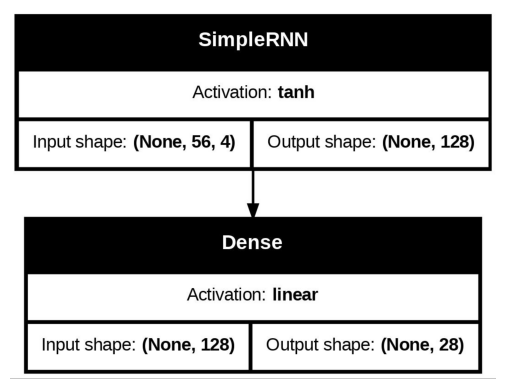

In [21]:
RNN_img_file = '/tmp/model_1.jpg'

plot_model(
    rnn_model,
    to_file=RNN_img_file,
    show_shapes=True,
    show_layer_activations=True,
)

RNN_img = plt.imread(RNN_img_file)
plt.axis('off')
plt.imshow(RNN_img)
plt.show()

In [22]:
# Make predictions
rnn_pred = rnn_model.predict(X_test)

# Inverse transform to original scale
rnn_pred = target_scaler.inverse_transform(rnn_pred)

# Inverse transform the true values for comparison
y_test = target_scaler.inverse_transform(y_test_trans)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


RMSE: 2.8106484077683223
R2 Score: 0.7039742360114551


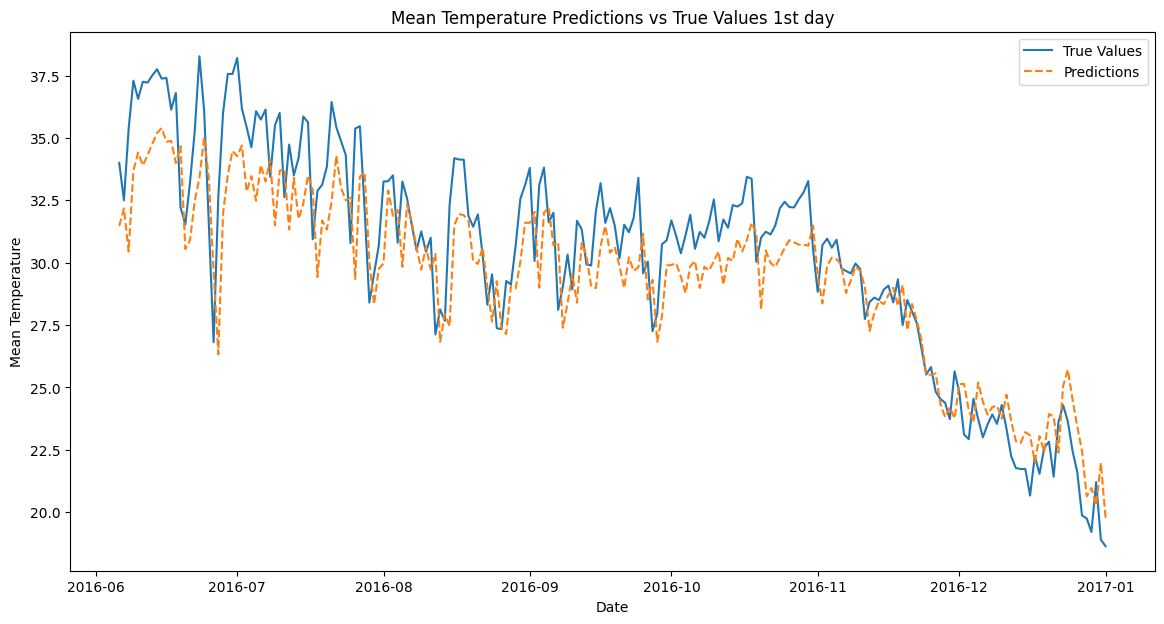

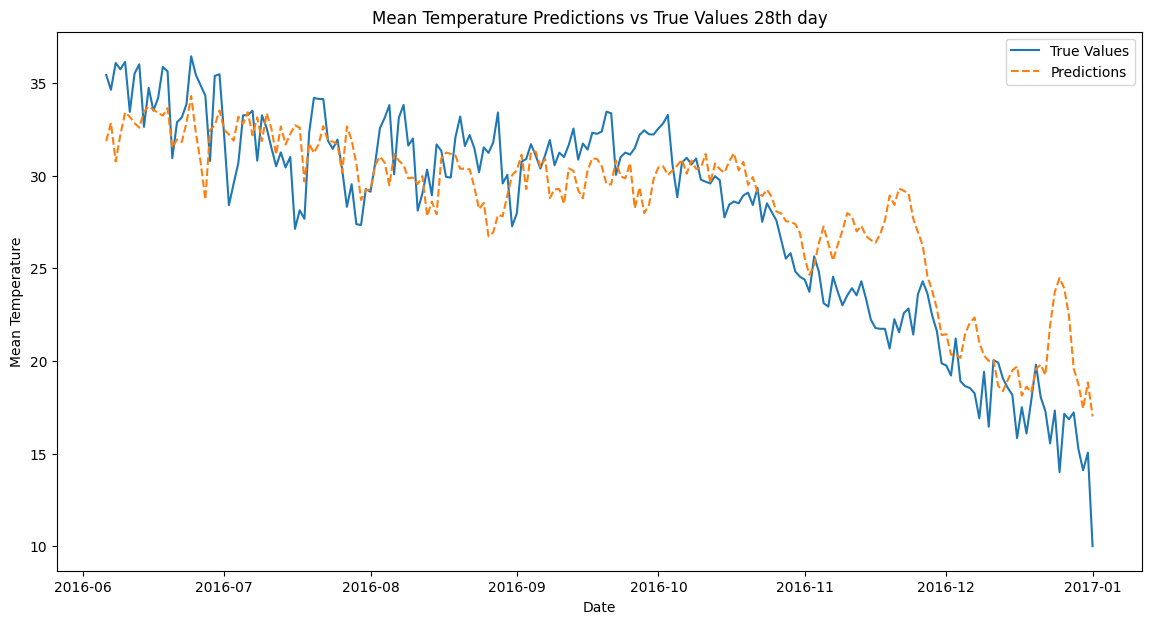

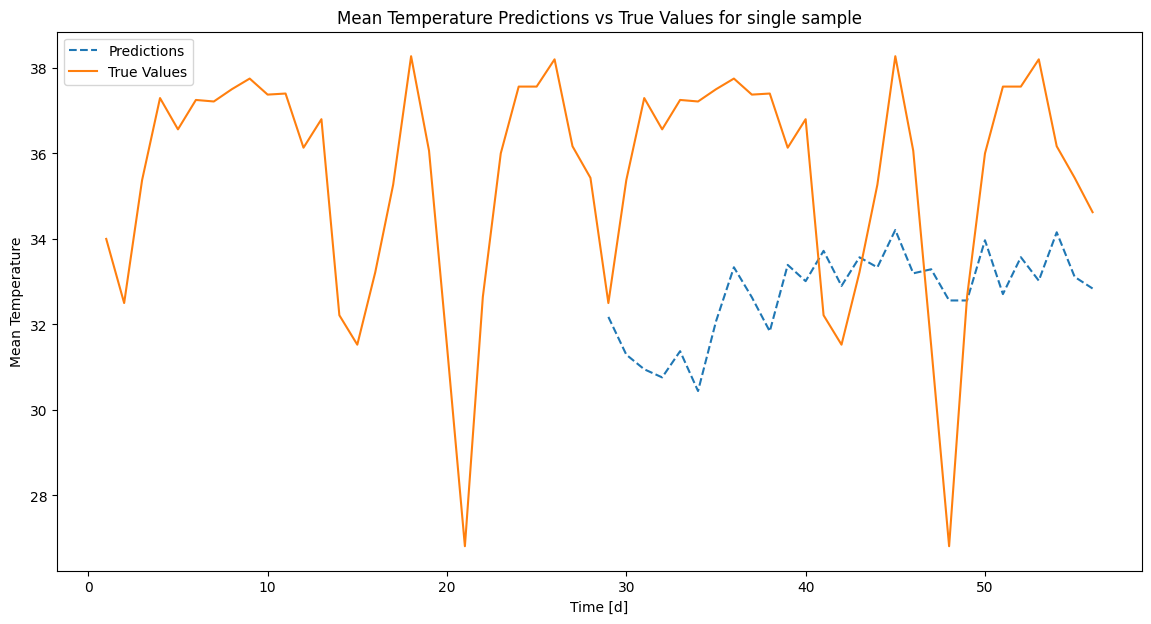

In [23]:
# Calculate RMSE and R2 scores
rmse = np.sqrt(mean_squared_error(y_test.reshape(-1), rnn_pred.reshape(-1)))
r2 = r2_score(y_test.reshape(-1), rnn_pred.reshape(-1))

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test[:,0], label='True Values')
plt.plot(df.index[-len(y_test):], rnn_pred[:,0], label='Predictions', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values 1st day')
plt.legend()
plt.show()


plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test[:,forecast_steps-1], label='True Values')
plt.plot(df.index[-len(y_test):], rnn_pred[:,forecast_steps-1], label='Predictions', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values ' + str(forecast_steps) + 'th day')
plt.legend()
plt.show()

sample = 1

if rnn_pred.shape[1] > 1:
  plt.figure(figsize=(14, 7))
  plt.plot(range(1,sequence_length+1), [None]*forecast_steps + rnn_pred[sample].tolist(), label='Predictions', linestyle='dashed')
  plt.plot(range(1,sequence_length+1), np.concatenate([y_test[sample-1], y_test[sample]]), label='True Values')

  plt.xlabel('Time [d]')
  plt.ylabel('Mean Temperature')
  plt.title('Mean Temperature Predictions vs True Values for single sample')
  plt.legend()
  plt.show()

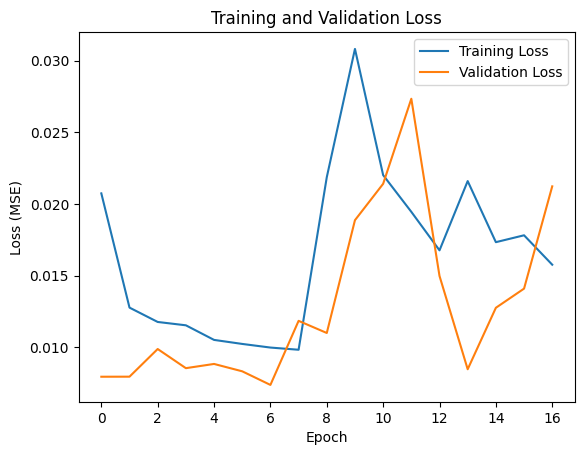

In [24]:
# Get training and validation losses from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot loss values over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Sensitivity and ablation analysis

In [26]:
# Hyperparameter analysis
num_units_range = [64, 128, 256]
batch_size_range = [1, 16, 32]
hyperparameter_results = []

# Iterate over different hyperparameters
for num_units, batch_size in itertools.product(num_units_range, batch_size_range):
    print(f"Testing num_units={num_units}, batch_size={batch_size}")

    model = Sequential()
    model.add(SimpleRNN(num_units, activation='tanh', input_shape=(sequence_length, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train, y_train, epochs=30, callbacks=[early_stopping], batch_size=batch_size, verbose=0)

    loss = model.evaluate(X_test, y_test, verbose=0)

    lstm_pred = model.predict(X_test,verbose=0)
    rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))

    r2 = r2_score(y_test, lstm_pred)
    hyperparameter_results.append((num_units, batch_size, loss, rmse,r2))

# Display results
for result in hyperparameter_results:
    print(f"num_units={result[0]}, batch_size={result[1]} -> Loss: {result[2]}, RMSE {result[3]}, R2 {result[4]}")

Testing num_units=64, batch_size=1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


ValueError: y_true and y_pred have different number of output (28!=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Feature Importance (Permutation):
meantemp: 0.6217570173812419
humidity: -0.013331828396076162
wind_speed: -0.13174203473408852
meanpressure: -0.08650909197501733


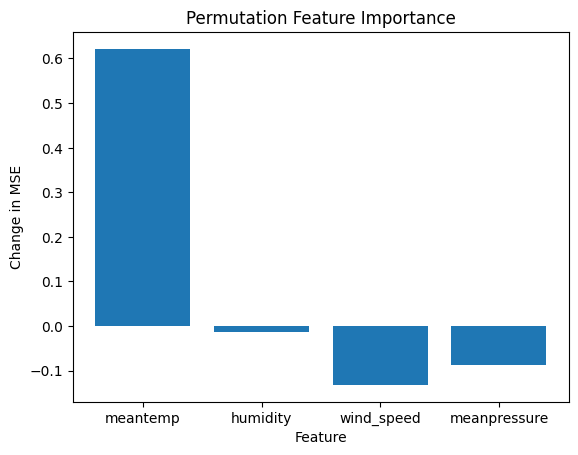

In [27]:
# Sensitivity analysis
# Baseline performance
baseline_mse = mean_squared_error(y_test, rnn_model.predict(X_test))

# Permutation importance
feature_importance = {}
for i, feature in enumerate(['meantemp', 'humidity', 'wind_speed', 'meanpressure']):
    X_test_permuted = X_test.copy()
    np.random.shuffle(X_test_permuted[:, :, i])  # Permute the feature
    permuted_mse = mean_squared_error(y_test, rnn_model.predict(X_test_permuted))
    feature_importance[feature] = permuted_mse - baseline_mse

print("Feature Importance (Permutation):")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance}")
plt.bar(feature_importance.keys(), feature_importance.values())
plt.xlabel('Feature')
plt.ylabel('Change in MSE')
plt.title('Permutation Feature Importance')
plt.show()


LSTM

In [28]:
num_hidden_units = 128
epochs = 30
batch_size = 3
patiance = 10

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(num_hidden_units, activation='tanh', input_shape=(sequence_length, X_train.shape[2])))
lstm_model.add(Dense(forecast_steps))
lstm_model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=patiance, restore_best_weights=True)

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test_trans), batch_size=batch_size, callbacks=[early_stopping])

# Evaluate the model
loss = lstm_model.evaluate(X_test, y_test_trans)
print(f'Validation Loss: {loss}')

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


362/362 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0616 - val_loss: 0.0072
Epoch 2/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0106 - val_loss: 0.0094
Epoch 3/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0088 - val_loss: 0.0066
Epoch 4/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0080 - val_loss: 0.0067
Epoch 5/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0074 - val_loss: 0.0051
Epoch 6/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 7/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 8/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0074 - val_loss: 0.0048
Epoch 9/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 10/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 11/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0065 - val_loss: 0.0041
Epoch 12/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.

In [29]:
lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 28)                  │           3,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 215,126 (840.34 KB)

 Trainable params: 71,708 (280.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 143,418 (560.23 KB)

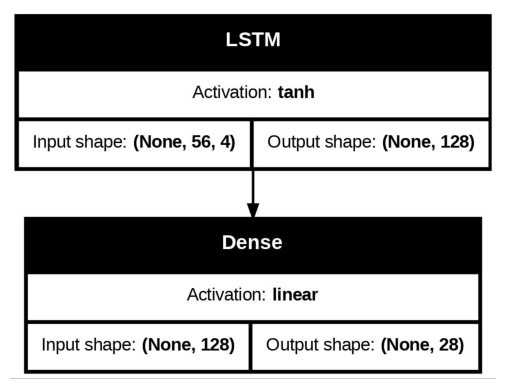

In [30]:
LSTM_img_file = '/tmp/model_2.jpg'

plot_model(
    lstm_model,
    to_file=LSTM_img_file,
    show_shapes=True,
    show_layer_activations=True,
)

LSTM_img = plt.imread(LSTM_img_file)
plt.axis('off')
plt.imshow(LSTM_img)
plt.show()

In [31]:
# Make predictions
lstm_pred = lstm_model.predict(X_test)

# Inverse transform to original scale
lstm_pred = target_scaler.inverse_transform(lstm_pred)

# Inverse transform the true values for comparison
y_test = target_scaler.inverse_transform(y_test_trans)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


RMSE: 2.0319263575342936
R2 Score: 0.845285009587657


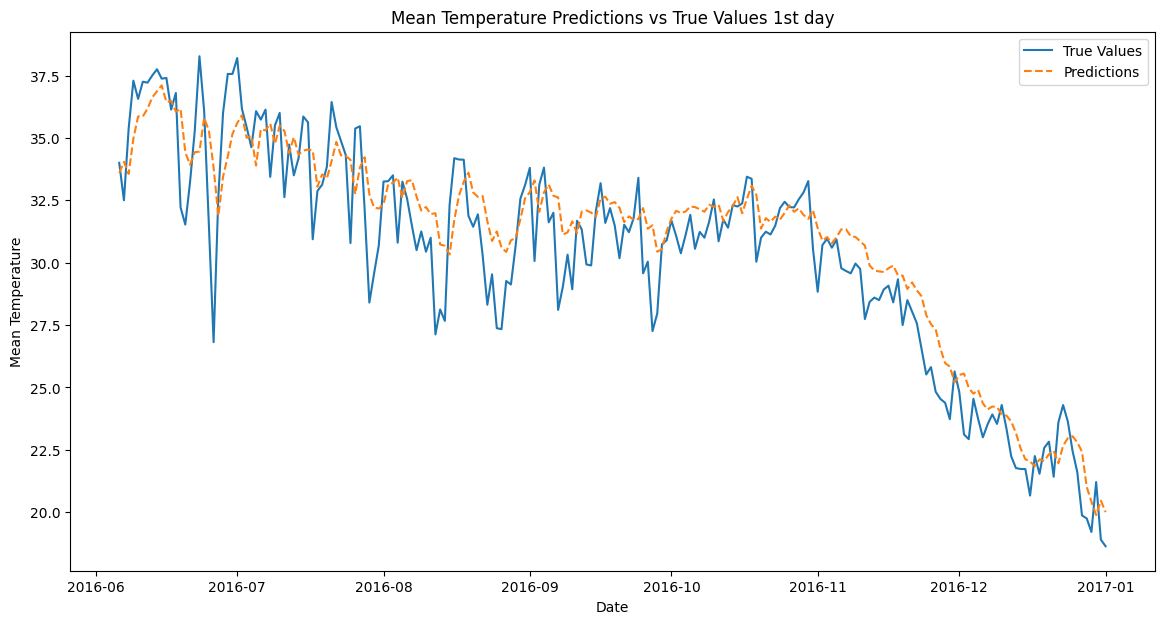

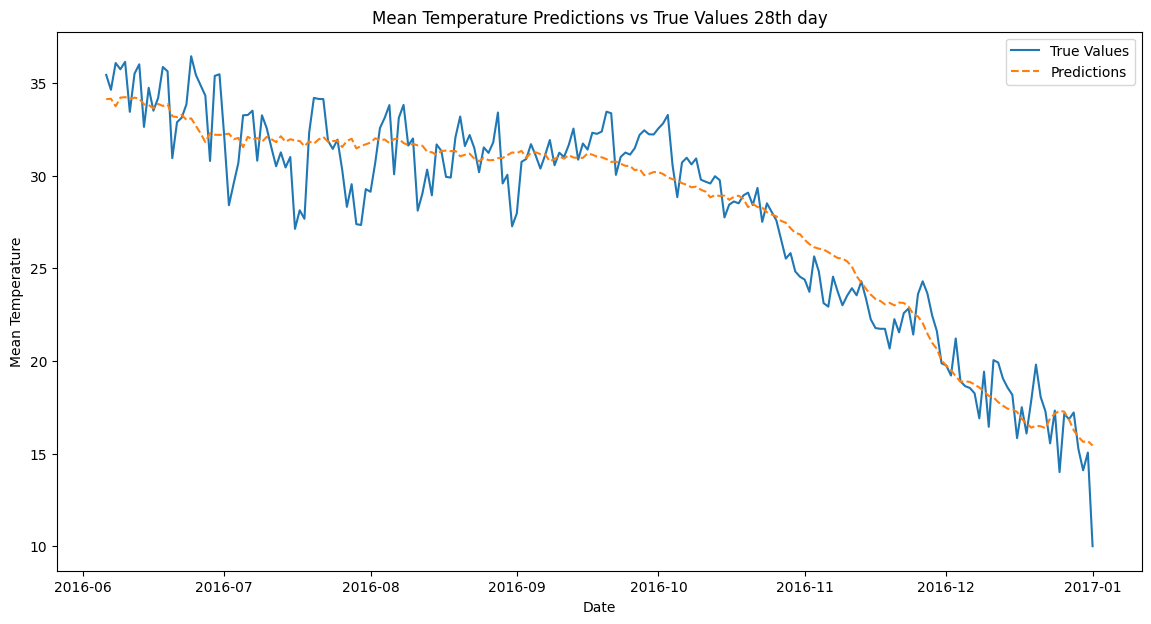

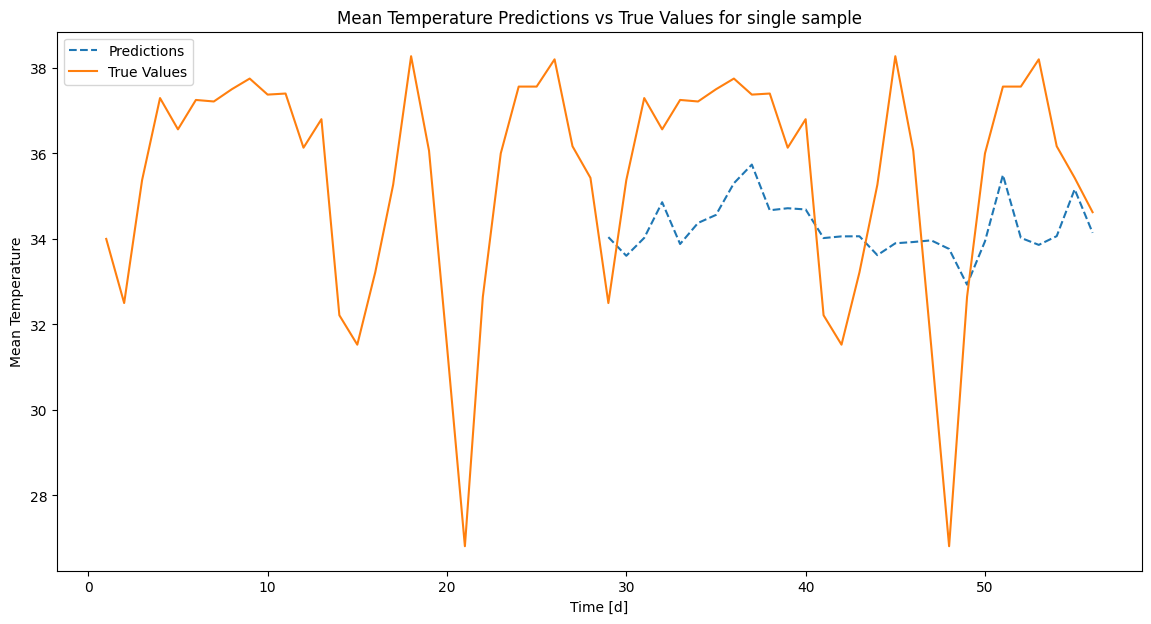

In [32]:
# Calculate RMSE and R2 scores
rmse = np.sqrt(mean_squared_error(y_test.reshape(-1), lstm_pred.reshape(-1)))
r2 = r2_score(y_test.reshape(-1), lstm_pred.reshape(-1))

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test[:,0], label='True Values')
plt.plot(df.index[-len(y_test):], lstm_pred[:,0], label='Predictions', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values 1st day')
plt.legend()
plt.show()


plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test[:,forecast_steps-1], label='True Values')
plt.plot(df.index[-len(y_test):], lstm_pred[:,forecast_steps-1], label='Predictions', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values ' + str(forecast_steps) + 'th day')
plt.legend()
plt.show()

sample = 1

if lstm_pred.shape[1] > 1:
  plt.figure(figsize=(14, 7))
  plt.plot(range(1,sequence_length+1), [None]*forecast_steps + lstm_pred[sample].tolist(), label='Predictions', linestyle='dashed')
  plt.plot(range(1,sequence_length+1), np.concatenate([y_test[sample-1], y_test[sample]]), label='True Values')

  plt.xlabel('Time [d]')
  plt.ylabel('Mean Temperature')
  plt.title('Mean Temperature Predictions vs True Values for single sample')
  plt.legend()
  plt.show()

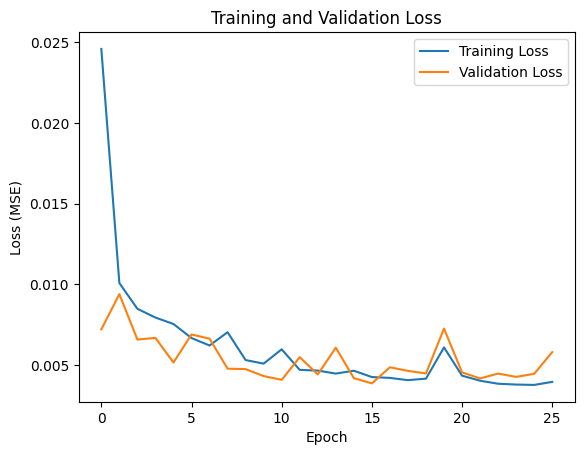

In [33]:
# Get training and validation losses from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot loss values over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [34]:
# Hyperparameter analysis
num_units_range = [64, 128, 256]
batch_size_range = [1, 3, 5]
hyperparameter_results = []

# Iterate over different hyperparameters
for num_units, batch_size in itertools.product(num_units_range, batch_size_range):
    print(f"Testing num_units={num_units}, batch_size={batch_size}")

    model = Sequential()
    model.add(LSTM(num_units, activation='tanh', input_shape=(sequence_length, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train, y_train, epochs=30, callbacks=[early_stopping], batch_size=batch_size, verbose=0)

    loss = model.evaluate(X_test, y_test, verbose=0)

    lstm_pred = model.predict(X_test,verbose=0)
    rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))

    r2 = r2_score(y_test, lstm_pred)
    hyperparameter_results.append((num_units, batch_size, loss, rmse,r2))

# Display results
for result in hyperparameter_results:
    print(f"num_units={result[0]}, batch_size={result[1]} -> Loss: {result[2]}, RMSE {result[3]}, R2 {result[4]}")

Testing num_units=64, batch_size=1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


ValueError: y_true and y_pred have different number of output (28!=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Feature Importance (Permutation):
meantemp: -0.015516970506496364
humidity: 0.24206849921802132
wind_speed: -0.16284667640422867
meanpressure: 0.386252951061806


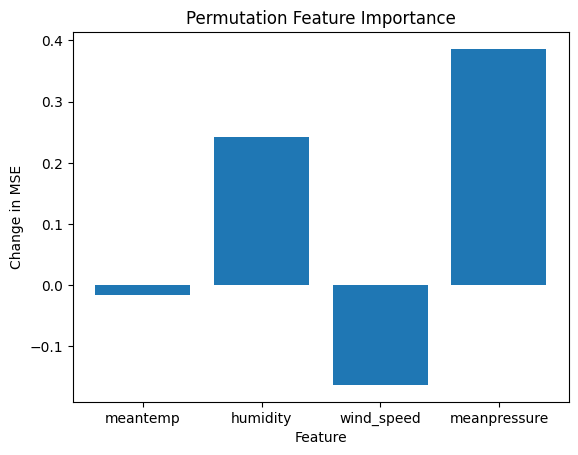

In [35]:
# Sensitivity analysis
# Baseline performance
baseline_mse = mean_squared_error(y_test, lstm_model.predict(X_test))

# Permutation importance
feature_importance = {}
for i, feature in enumerate(['meantemp', 'humidity', 'wind_speed', 'meanpressure']):
    X_test_permuted = X_test.copy()
    np.random.shuffle(X_test_permuted[:, :, i])  # Permute the feature
    permuted_mse = mean_squared_error(y_test, lstm_model.predict(X_test_permuted))
    feature_importance[feature] = permuted_mse - baseline_mse

print("Feature Importance (Permutation):")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance}")
plt.bar(feature_importance.keys(), feature_importance.values())
plt.xlabel('Feature')
plt.ylabel('Change in MSE')
plt.title('Permutation Feature Importance')
plt.show()


# TNN

TNN (plan)

In [36]:
# Transformer model building code from example: https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    # Match feature dimensions explicitly
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


# function to build transformer nn
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return Model(inputs, outputs)


In [37]:
input_shape = (X_train.shape[1], X_train.shape[2])

modelTransformer = build_model(
    input_shape,
    #head_size=256,
    head_size=64,
    num_heads=4,
    ff_dim=64,
    #num_transformer_blocks=4,
    num_transformer_blocks=6,
    mlp_units=[64],
    #mlp_units=[128],
    dropout=0,
    mlp_dropout=0,
)

modelTransformer.compile(
    loss="mean_squared_error",
    optimizer=Adam(learning_rate=1e-2)
)
# Tested leranign rate  1e-3 1e-4 and 1e-5
modelTransformer.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 56, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 56, 4)          │              8 │ input_layer_6[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 56, 4)          │          4,868 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 56, 4)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 4)          │              0 │ dropout_1[0][0],       │
│                           │                        │                │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 56, 4)          │              8 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 56, 64)         │            320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 56, 64)         │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 56, 4)          │            260 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 56, 4)          │              0 │ conv1d_1[0][0],        │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 56, 4)          │              8 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 56, 4)          │          4,868 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 56, 4)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 56, 4)          │              0 │ dropout_4[0][0],       │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 56, 4)          │              8 │ add_2[0][0]            │
│ (LayerNormalization) 

 Total params: 36,497 (142.57 KB)

 Trainable params: 36,497 (142.57 KB)

 Non-trainable params: 0 (0.00 B)

sequence length = 4
- dropout = 0.1
Score (RMSE): 0.06275645779984174
R2 Score: 0.8691105215746717
train time 1min


sequence length = 4
- drop out 0
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step
RMSE: 0.06251693865176437
R2 Score: 0.8701077323963469
train time 45s



with sequence lenght 7:
- with learning rate  1e-3
- dropout 0
RMSE: 0.0568338819045151
R2 Score: 0.8935555876364407


with sequence lenght 7:
- dropout 0.1
RMSE: 0.06692122496300261
R2 Score: 0.852417116447851
train time 1min



with sequence length 31:
- drop out 0
RMSE: 0.07452794653307342
R2 Score: 0.8293432661221862
train time 4min


**with sequence lenght 7 and dropout 0**

learning rate:
- 1e-2 :
RMSE: 0.07685036373591297
R2 Score: 0.80537434711141
train time 45sek

learning rate:
- 1e-3 :
RMSE: 0.0568338819045151
R2 Score: 0.8935555876364407
train time 1min

learning rate:
- 1e-4:
RMSE: 0.061317551332929744
R2 Score: 0.8760981376142318
train time 2min

learning rate:
- 1e-5
RMSE: 0.11784003295415955
R2 Score: 0.5423916522842287
train time 2min


In [38]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)
]

history_transformer = modelTransformer.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
)

modelTransformer.evaluate(X_test, y_test, verbose=1)

Epoch 1/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 440ms/step - loss: 4.5484 - val_loss: 0.1531
Epoch 2/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1163 - val_loss: 0.0255
Epoch 3/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0315 - val_loss: 0.0236
Epoch 4/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0239 - val_loss: 0.0224
Epoch 5/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0254 - val_loss: 0.0296
Epoch 6/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0230 - val_loss: 0.0164
Epoch 7/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0170 - val_loss: 0.0123
Epoch 8/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 9/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 10/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0148 - val_loss: 0.0121
Epoch 11/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0136 - val_loss: 0.0098
Epoch 12/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/ste

838.9306640625

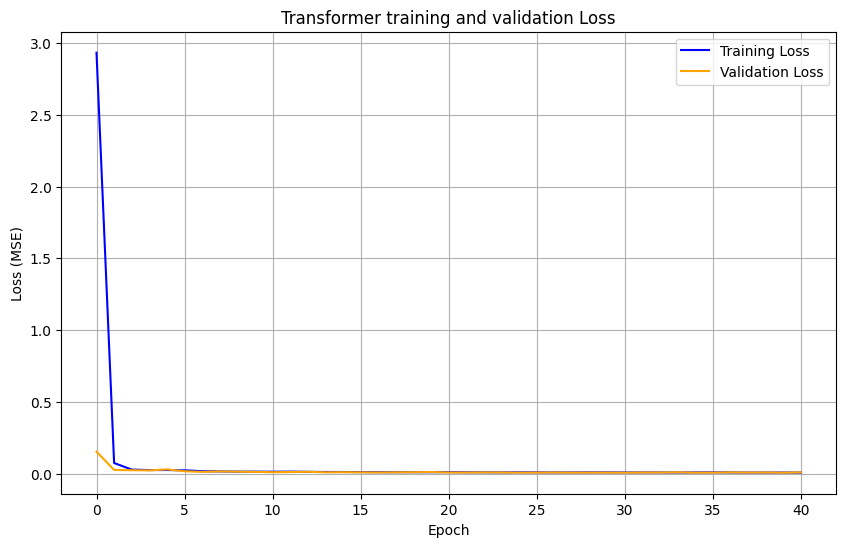

In [39]:
training_loss = history_transformer.history['loss']
validation_loss = history_transformer.history['val_loss']


plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss', color='blue')
plt.plot(validation_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Transformer training and validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Evaluation metrics

transformer_pred = modelTransformer.predict(X_test)
score = np.sqrt(mean_squared_error(transformer_pred,y_test))
print("RMSE: {}".format(score))

r2 = r2_score(y_test, transformer_pred)
print(f"R2 Score: {r2}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step


ValueError: y_true and y_pred have different number of output (1!=28)

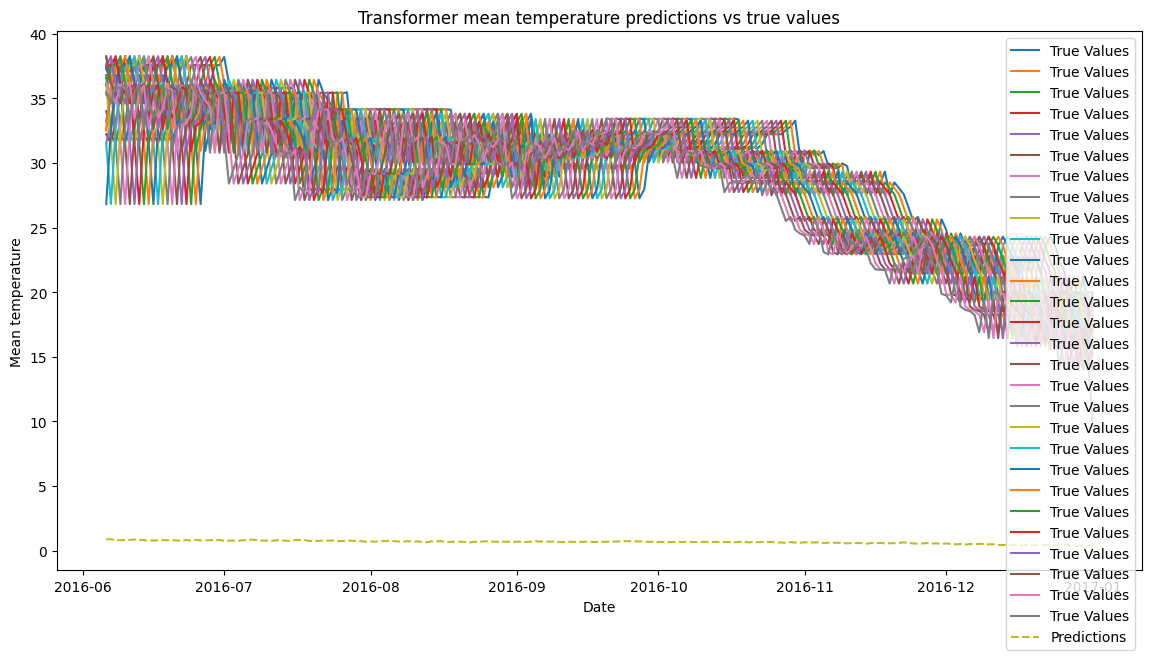

In [41]:
if transformer_pred.ndim > 1 and transformer_pred.shape[1] == 1:
    transformer_pred = transformer_pred.flatten()

plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Values')
plt.plot(df.index[-len(y_test):], transformer_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean temperature')
plt.title('Transformer mean temperature predictions vs true values')
plt.legend()
plt.show()


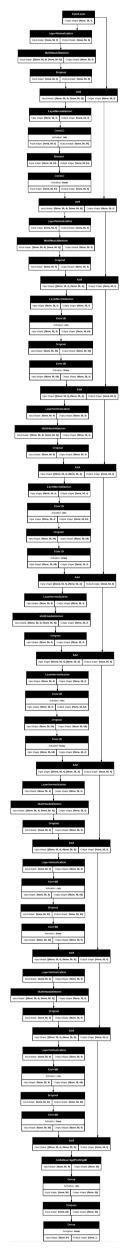

In [42]:
TNN_img_file = '/tmp/model_3.jpg'

plot_model(
    modelTransformer,
    to_file=TNN_img_file,
    show_shapes=True,
    show_layer_activations=True,
)

plt.figure(figsize=(16, 16))
TNN_img = plt.imread(TNN_img_file)
plt.axis('off')
plt.imshow(TNN_img)
plt.show()

TNN Testing the Forecasting Power

In [43]:
# Creating dataset for model training
df = climate_data_clean
train_split = 0.8
# Split the data into training and testing sets
train_size = int(len(df) * train_split)
dl_train, dl_test = df.iloc[:train_size], df.iloc[train_size:]
print(len(dl_train), len(dl_test))

# Normalizing data with min-max scaling
from sklearn.preprocessing import MinMaxScaler
# Initialize the MinMaxScaler
minmax_scaler = MinMaxScaler()

dl_train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']] = minmax_scaler.fit_transform(dl_train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])
dl_test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']] = minmax_scaler.transform(dl_test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])

# Creating data set
def create_multistep_dataset(X, y, time_steps, forecast_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_steps + 1):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[(i + time_steps):(i + time_steps + forecast_steps)].values)
    return np.array(Xs), np.array(ys)


#forecast_length = 1
#sequence_length = 7

forecast_length = 56
sequence_length = forecast_length*2

X_train_m, y_train_m = create_multistep_dataset(dl_train, dl_train['meantemp'], sequence_length, forecast_length)
X_test_m, y_test_m = create_multistep_dataset(dl_test, dl_test['meantemp'], sequence_length,forecast_length)

1169 293


<ipython-input-43-6c7ee2f68bf6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']] = minmax_scaler.fit_transform(dl_train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])
<ipython-input-43-6c7ee2f68bf6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']] = minmax_scaler.transform(dl_test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])


In [44]:
print(X_train.shape[0:])
print(y_train.shape[0:])
print(X_train_m.shape[0:])
print(y_train_m.shape[0:])

(1086, 56, 4)
(1086, 28)
(1002, 112, 4)
(1002, 56)


In [45]:
# TNN model architecture for multistep forecast

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    # Match feature dimensions explicitly
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


# function to build transformer nn
def build_model(
    input_shape,
    forecast_period,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(forecast_length)(x)

    return Model(inputs, outputs)


# building the model
input_shape = (X_train_m.shape[1], X_train_m.shape[2])  # window length & number of features
modelTransformer = build_model(
    input_shape,
    forecast_period=forecast_length,
    #head_size=256,
    head_size=64,
    num_heads=4,
    ff_dim=64,
    #num_transformer_blocks=4,
    num_transformer_blocks=6,
    mlp_units=[64],
    #mlp_units=[128],
    dropout=0,
    mlp_dropout=0,
)

# compile m,odel
modelTransformer.compile(
    loss="mean_squared_error",
    optimizer=Adam(learning_rate=1e-3)
)

modelTransformer.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 112, 4)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_12    │ (None, 112, 4)         │              8 │ input_layer_7[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_6    │ (None, 112, 4)         │          4,868 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 112, 4)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 112, 4)         │              0 │ dropout_20[0][0],      │
│                           │                        │                │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_13    │ (None, 112, 4)         │              8 │ add_12[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 112, 64)        │            320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 112, 64)        │              0 │ conv1d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 112, 4)         │            260 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 112, 4)         │              0 │ conv1d_13[0][0],       │
│                           │                        │                │ add_12[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 112, 4)         │              8 │ add_13[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_7    │ (None, 112, 4)         │          4,868 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 112, 4)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 112, 4)         │              0 │ dropout_23[0][0],      │
│                           │                        │                │ add_13[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 112, 4)         │              8 │ add_14[0][0]           │
│ (LayerNormalization) 

 Total params: 43,656 (170.53 KB)

 Trainable params: 43,656 (170.53 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
#Training the tnn model
#print(X_train_m.shape[0:])
#print(y_train_m.shape[0:]

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)
]

history_transformer = modelTransformer.fit(
    X_train_m,
    y_train_m,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
)

modelTransformer.evaluate(X_test_m, y_test_m, verbose=1)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - loss: 0.3222 - val_loss: 0.0933
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.0561 - val_loss: 0.0197
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0287 - val_loss: 0.0140
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0193 - val_loss: 0.0137
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0242 - val_loss: 0.0197
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0195 - val_loss: 0.0138
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0128 - val_loss: 0.0100
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0119 - val_loss: 0.0094
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0112 - val_loss: 0.0092
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0110 - val_loss: 0.0134
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0110 - val_loss: 0.0096
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 

0.014458787627518177

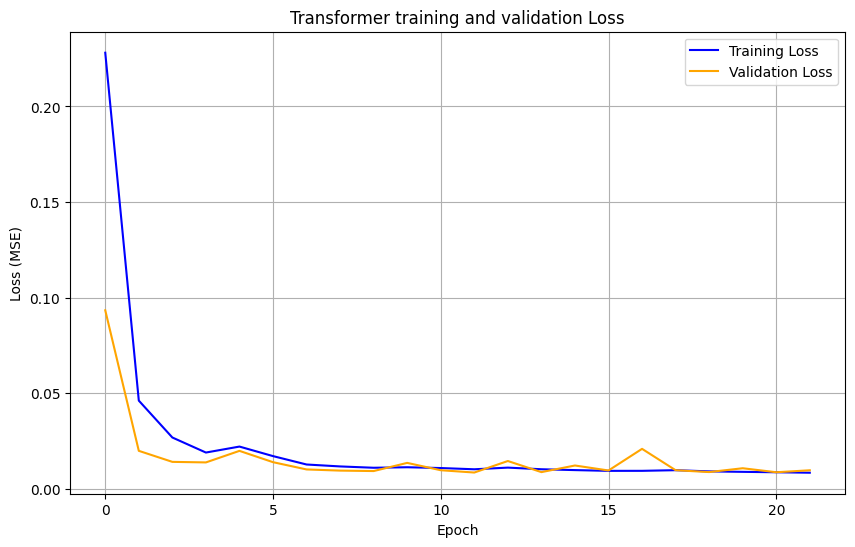

In [47]:
training_loss = history_transformer.history['loss']
validation_loss = history_transformer.history['val_loss']


plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss', color='blue')
plt.plot(validation_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Transformer training and validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
print(X_test_m.shape[:])
print(y_test_m.shape[:])

(126, 112, 4)
(126, 56)


In [49]:
y_pred_m = modelTransformer.predict(X_test_m)
print(y_pred_m)
print(y_pred_m.shape[:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step
[[0.7568069  0.736406   0.7923991  ... 0.71810335 0.7389245  0.738839  ]
 [0.77651346 0.76996887 0.7904628  ... 0.72640425 0.74303204 0.7269968 ]
 [0.7844231  0.7784819  0.8110472  ... 0.73924303 0.74608237 0.75565094]
 ...
 [0.3680377  0.34666574 0.3740744  ... 0.35827103 0.35474163 0.33052918]
 [0.34099835 0.3373283  0.36711922 ... 0.3368368  0.34718895 0.3797045 ]
 [0.31909478 0.3623932  0.3711322  ... 0.33531478 0.34227234 0.32724214]]
(126, 56)


In [50]:
# normalized predictions
y_pred_m = modelTransformer.predict(X_test_m)

#Evaluation metrics
mse = mean_squared_error(y_test_m.reshape(-1), y_pred_m.reshape(-1))
print(f"Multi preds RMSE: {mse}")

# flattening the values fir R2 calculation
y_test_flat = y_test_m.reshape(-1)
y_pred_flat = y_pred_m.reshape(-1)
r2 = r2_score(y_test_flat, y_pred_flat)
print(f"Multi preds R2 Score: {r2}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Multi preds RMSE: 0.014458786885300546
Multi preds R2 Score: 0.2121725851704206


Forecasting power


**forecast_length = 1 & sequence_length 7**

Multi preds RMSE: 0.004671164730933246

Multi preds R2 Score: 0.8460664054355885


**forecast_length = 7 & sequence_length 14**

Multi preds RMSE: 0.006019356566007423

Multi preds R2 Score: 0.7917254401771254


**forecast_length = 14 & sequence_length 28**

Multi preds RMSE: 0.007516551482331121

Multi preds R2 Score: 0.7350730823224043



**forecast_length = 28 & sequence_length 56**

Multi preds RMSE: 0.005281720357395312

Multi preds R2 Score: 0.7881801016934167


**forecast_length = 56 & sequence_length 112**

Multi preds RMSE: 0.017549735508834756

Multi preds R2 Score: 0.043753610413577726